In [51]:
import json
import pandas as pd
import re

In [52]:
with open('tioberny.txt', 'r', encoding='utf-16') as file:
    tweets = [json.loads(line) for line in file]

tioberny_tweets = pd.DataFrame(tweets)

In [53]:
with open('traficogt.txt', 'r', encoding='utf-16') as file:
    tweets = [json.loads(line) for line in file]

traficogt_tweets = pd.DataFrame(tweets)


In [54]:
print(tioberny_tweets.columns)
print(traficogt_tweets.columns)


Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'bookmarkedCount', 'conversationId', 'conversationIdStr', 'hashtags',
       'cashtags', 'mentionedUsers', 'links', 'viewCount', 'retweetedTweet',
       'quotedTweet', 'place', 'coordinates', 'inReplyToTweetId',
       'inReplyToTweetIdStr', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', 'card', '_type'],
      dtype='object')
Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'bookmarkedCount', 'conversationId', 'conversationIdStr', 'hashtags',
       'cashtags', 'mentionedUsers', 'links', 'viewCount', 'retweetedTweet',
       'quotedTweet', 'place', 'coordinates', 'inReplyToTweetId',
       'inReplyToTweetIdStr', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', 'card', '_type'],
      dtype='object')


Convertir a minúsculas

In [55]:
tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].str.lower()
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].str.lower()


Quitar URLs

In [56]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].apply(remove_urls)
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].apply(remove_urls)


Quitar emoticones

In [57]:
def remove_emoticons(text):
    return re.sub(r'[^\w\s]', '', text)

tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].apply(remove_emoticons)
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].apply(remove_emoticons)


Quitar signos de puntuación (exceptuando "@" y "#")

In [60]:
tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].str.replace(r'[^\w\s@#]', '', regex=True)
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].str.replace(r'[^\w\s@#]', '', regex=True)


3.2. Extraer menciones, respuestas y retweets

In [61]:
# Crear listas para almacenar las interacciones
interactions = []

for index, row in tioberny_tweets.iterrows():
    user_id = row['user']['id_str']
    text = row['rawContent']
    
    # Extraer menciones
    mentions = re.findall(r'@(\w+)', text)  # Extraer nombres de usuario mencionados
    mentions = [mention.lower() for mention in mentions]  # Normalizar
    
    # Comprobar si es una respuesta o un retweet
    is_reply = row['inReplyToUser'] is not None
    is_retweet = row['retweetedTweet'] is not None

    interactions.append({
        'user_id': user_id,
        'mentions': mentions,
        'is_reply': is_reply,
        'is_retweet': is_retweet,
        'text': text
    })

interactions_df = pd.DataFrame(interactions)


3.3. Preprocesar datos eliminando duplicados y normalizando

In [62]:
# Eliminar duplicados
interactions_df.drop_duplicates(subset=['user_id', 'text'], inplace=True)

# Normalizar menciones
interactions_df['mentions'] = interactions_df['mentions'].apply(lambda x: [mention.lower() for mention in x])


3.4. Crear una estructura de datos eficiente para el análisis de redes

In [64]:
!pip install networkx

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 7.1 MB/s eta 0:00:00


In [65]:
import networkx as nx

# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar nodos y aristas
for _, row in interactions_df.iterrows():
    user_id = row['user_id']
    mentions = row['mentions']
    
    # Añadir nodo para el usuario
    if not G.has_node(user_id):
        G.add_node(user_id)

    # Añadir aristas por cada mención
    for mention in mentions:
        G.add_edge(user_id, mention)  # Interacción dirigida

# Convertir a una matriz de adyacencia si es necesario
adjacency_matrix = nx.to_numpy_array(G)


In [66]:
total_tweets_tioberny = len(tioberny_tweets)
total_tweets_traficogt = len(traficogt_tweets)

print(f"Número total de tweets en tioberny: {total_tweets_tioberny}")
print(f"Número total de tweets en traficogt: {total_tweets_traficogt}")


Número total de tweets en tioberny: 5019
Número total de tweets en traficogt: 5605


In [72]:
# Obtener IDs de usuario de manera correcta
unique_users_tioberny = tioberny_tweets['user'].apply(lambda x: x['id_str']).nunique()
unique_users_traficogt = traficogt_tweets['user'].apply(lambda x: x['id_str']).nunique()

print(f"Número de usuarios únicos en tioberny: {unique_users_tioberny}")
print(f"Número de usuarios únicos en traficogt: {unique_users_traficogt}")



Número de usuarios únicos en tioberny: 2620
Número de usuarios únicos en traficogt: 2072


In [73]:
total_mentions_tioberny = interactions_df['mentions'].explode().nunique()
total_mentions_traficogt = interactions_df['mentions'].explode().nunique()

print(f"Número total de menciones en tioberny: {total_mentions_tioberny}")
print(f"Número total de menciones en traficogt: {total_mentions_traficogt}")


Número total de menciones en tioberny: 0
Número total de menciones en traficogt: 0


In [74]:
hashtags_tioberny = tioberny_tweets['hashtags'].explode().value_counts()
hashtags_traficogt = traficogt_tweets['hashtags'].explode().value_counts()

print("Hashtags más frecuentes en tioberny:")
print(hashtags_tioberny.head(10))

print("Hashtags más frecuentes en traficogt:")
print(hashtags_traficogt.head(10))


Hashtags más frecuentes en tioberny:
hashtags
URGENTE                         26
GuatemalaSaleAdelante           25
MinfinSaleAdelante              17
Guatemala                       15
Presupuesto2025                 14
UnPresupuestoParaLaPoblación    13
EnElPaísDCA                     12
NacionalesAGN                    8
ElEstor                          7
XelaNews                         7
Name: count, dtype: int64
Hashtags más frecuentes en traficogt:
hashtags
AHORA                     18
AhoraLH                   18
Guatemala                 16
RenuncienGolpistas        13
URGENTE                   10
guatemala                  9
ParoNacionalIndefinido     9
ParoNacionaIndefinido      8
Ahora                      8
LaHoraDeActualizarnos      8
Name: count, dtype: int64


In [76]:
!pip install wordcloud

In [78]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

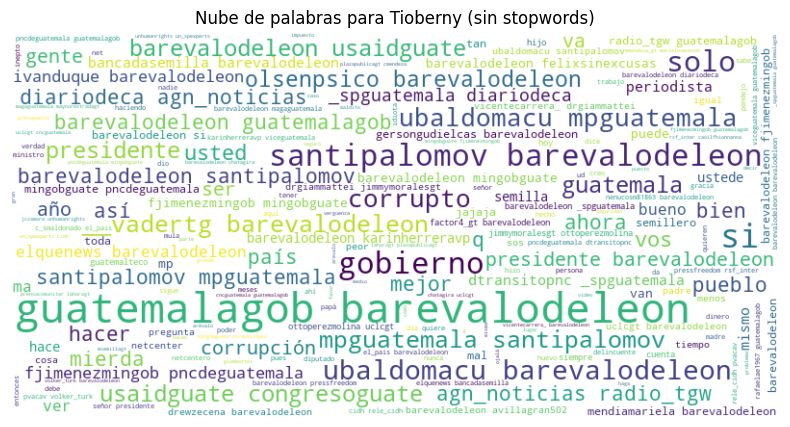

In [79]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Obtener stopwords en español
stop_words = set(stopwords.words('spanish'))

# Unir todos los textos para crear la nube, excluyendo las stopwords
text_tioberny = ' '.join(tioberny_tweets['rawContent'])
text_tioberny_filtered = ' '.join([word for word in text_tioberny.split() if word not in stop_words])

# Crear la nube de palabras
wordcloud_tioberny = WordCloud(width=800, height=400, background_color='white').generate(text_tioberny_filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tioberny, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras para Tioberny (sin stopwords)')
plt.show()
